# Python для анализа данных

*Алла Тамбовцева, НИУ ВШЭ*

## Web-scraping

Мы уже немного познакомились со структурой html-файлов, теперь попробуем выгрузить информацию из реальной страницы, а точнее, с реального сайта [nplus1.ru](https://nplus1.ru/).

**Наша задача:** выгрузить недавние новости в датафрейм `pandas`, чтобы потом сохранить все в csv-файл.

Сначала сгрузим весь html-код страницы и сохраним его в отдельную переменную. Для этого нам понадобится библиотека `requests`. Импортируем её:

In [1]:
import requests

Сохраним ссылку на главную страницу сайта в переменную `url` для удобства и выгрузим страницу. (Разумеется, это будет работать при подключении к интернету. Если соединение будет отключено, Python выдаст `NewConnectionError`).

In [2]:
url = 'https://nplus1.ru/' # сохраняем
page = requests.get(url) # загружаем страницу по ссылке

Если мы просто посмотрим на объект, мы ничего особенного не увидим:

In [3]:
page  # response 200 - страница загружена

<Response [200]>

In [4]:
# page.text

Импортируем функцию `BeautifulSoup` из библиотеки `bs4` (от *beautifulsoup4*) и заберём со страницы `page` код html в виде текста. 

In [5]:
from bs4 import BeautifulSoup  # не спрашивайте, почему BeautifulSoup

In [6]:
soup = BeautifulSoup(page.text, 'html')

Если выведем `soup` на экран, мы увидим то же самое, что в режиме разработчика или в режиме происмотра исходного кода (`view-source` через *Ctrl+U* в Google Chrome).

In [7]:
# soup

Для просмотра выглядит не очень удобно.  «Причешем» наш `soup` – воспользуемся методом `.prettify()` в сочетании с функцией `print()`.

In [8]:
# print(soup.prettify())

В такой выдаче ориентироваться гораздо удобнее (но при желании, то же можно увидеть в браузере, на большом экране).


Чтобы сгрузить все новости с главной страницы сайта, нужно собрать все ссылки на страницы с этими новостями. Ссылки в html-файле всегда заключены в тэг `<a></a>` и имеют атрибут `href`. Посмотрим на кусочки кода, соответствующие всем ссылкам на главной странице сайта:

In [10]:

# for link in soup.find_all('a'):
#     print(link.get('href'))
#     break

Ссылок много. Но нам нужны только новости – ссылки, которые начинаются со слова `/news`. Добавим условие: будем выбирать только те ссылки, в которых есть `/news`. Создадим пустой список `urls` и будем добавлять в него только ссылки, которые удовлетворяют этому условию.

In [11]:
# urls = []

# for link in soup.find_all('a'):
#     if '/news' in link.get('href'):
#         urls.append('https://nplus1.ru'+link.get('href'))

urls = [link.get('href') 
        for link in soup.find_all('a') 
        if 'https://nplus1.ru/news/2023' in link.get('href')]

Ссылки, которые у нас есть в списке `urls`, относительные: они неполные, начало ссылки (название сайта) отсутствует. Давайте превратим их в абсолютные ‒ склеим с ссылкой https://nplus1.ru.

In [12]:
urls[:5]

['https://nplus1.ru/news/2023/10/17/glass-windows',
 'https://nplus1.ru/news/2023/10/17/candida-amyloids',
 'https://nplus1.ru/news/2023/10/17/naduvnoi-robot-avatar',
 'https://nplus1.ru/news/2023/10/17/al-ghoreifa',
 'https://nplus1.ru/news/2023/10/17/fur-seals']

In [26]:
# full_urls = []

# for u in urls:
#     res = 'https://nplus1.ru' + u
#     full_urls.append(res) 

# full_urls

In [15]:
# urls

Теперь наша задача сводится к следующему: изучить одну страницу с новостью, научиться из нее вытаскивать текст и всю необходимую информацию, а потом применить весь набор действий к каждой ссылке из `full_urls` в цикле. Посмотрим на новость с индексом 1, у вас может быть другая, новости обновляются.

In [13]:
url0 = urls[0]

page0 = requests.get(url0)
soup0 = BeautifulSoup(page0.text, 'html')

In [14]:
url0

'https://nplus1.ru/news/2023/10/17/glass-windows'

В коде каждой страницы с новостью есть часть с мета-информацией: датой, именем автора и проч. Такая информация окружена тэгом `<meta></meta>`. Посмотрим:

In [15]:
soup0.find_all('meta')

[<meta charset="utf-8"/>,
 <meta content="width=device-width, initial-scale=1" name="viewport"/>,
 <meta content="#f26e40" name="msapplication-TileColor"/>,
 <meta content="#ffffff" name="theme-color"/>,
 <meta content="8c90b02c84ac3b72" name="yandex-verification"/>,
 <meta content="b419949322895fc9106e24ed01be58ac" name="pmail-verification"/>,
 <meta content="N + 1 — главное издание о науке, технике и технологиях" name="description"/>,
 <meta content="N + 1 — главное издание о науке, технике и технологиях" property="og:site_name"/>,
 <meta content="Викингов заподозрили в стеклении окон" property="og:title"/>,
 <meta content="https://minio.nplus1.ru/app-images/845296/652d5e1bec5f8_cover_share.jpeg" property="og:image"/>,
 <meta content="https://nplus1.ru/news/2023/10/17/glass-windows" property="og:url"/>,
 <meta content="N + 1 — главное издание о науке, технике и технологиях" property="og:description"/>,
 <meta content="article" property="og:type"/>,
 <meta content="2023-10-17" itempro

Из этого списка нам нужны части с именем автора, датой, заголовком и кратким описанием. Воспользуемся поиском по атрибуту `name`. Передадим функции `find_all()` в качестве аргумента словарь с названием и значением атрибута: 

In [16]:
soup0.find_all('meta', {'name' : 'author'}) # например, автор

[<meta content="Михаил Подрезов" name="author"/>]

Теперь выберем единственный элемент полученного списка (с индексом 0):

In [17]:
soup0.find_all('meta', {'name' : 'author'})[0]

<meta content="Михаил Подрезов" name="author"/>

Нам нужно вытащить из этого объекта `content` – имя автора. Посмотрим на атрибуты:

In [18]:
soup0.find_all('meta', {'name' : 'author'})[0].get('content')

'Михаил Подрезов'

Как получить отсюда `content`? Очень просто, ведь это словарь! А доставать из словаря значение по ключу мы умеем.

In [19]:
author = soup0.find_all('meta', {'name' : 'author'})[0].attrs
author

{'name': 'author', 'content': 'Михаил Подрезов'}

Аналогичным образом извлечем дату, заголовок и описание.

In [20]:
soup0.find_all('meta', {'property' : 'og:title'})[0].get('content')

'Викингов заподозрили в\xa0стеклении окон'

In [21]:
date = soup0.find_all('meta', {'itemprop' : 'datePublished'})[0].get('content')
title = soup0.find_all('meta', {'property' : 'og:title'})[0].get('content')
description = soup0.find_all('h1', {'class':'text-34 md:text-42 xl:text-52 break-words'})[0].get_text().strip() \
+ '\n' + soup0.find_all('p', {'class':"text-36 md:text-44 xl:text-54 font-spectral text-main-gray mb-6"})[0].get_text().strip()



In [22]:
description

'Викингов заподозрили в\xa0стеклении окон\nРанее осколки стекол из\xa0поселений этого времени считались более поздними'

Осталось вытащить рубрики и сложность текста. Если мы посмотрим на исходный код страницы, мы увидим, что нужная нам информация находится в тэгах `<p></p>`:

In [23]:
new_data = soup0.find_all('div', {'class':"flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9"})[0].find_all('span')[1:]

time_published = new_data[0].get_text()
date_published = new_data[1].get_text()
complexity = new_data[2].get_text()
themes = ', '.join(i.get_text() for i in new_data[3:])

In [24]:
paragraphs = soup0.find_all('p', {'class': 'mb-6'})[1:]


In [25]:
links = set()
for p in paragraphs:
    links|={i.get('href') for i in p.find_all('a')}
links = ', '.join(links)

In [26]:
full_text = '\n'.join([p.get_text() for p in paragraphs])

Не прошло и двух пар, как мы разобрались со всем :) Теперь осталось совсем чуть-чуть. Написать готовую функцию для всех проделанных нами действий и применить ее в цикле для всех ссылок в списке `full_urls`. Напишем! Аргументом функции будет ссылка на новость, а возвращать она будет текст новости и всю необходимую информацию (дата, автор, сложность и проч.). Скопируем все строки кода выше.

In [27]:
def GetNews(url0):
    """
    Returns a tuple with 
    url0, date_published, time_published, author, description, title, complexity, themes, links,full_text
    Parameters:
    
    url0 is a link to the news (string)
    """
    page0 = requests.get(url0)
    soup0 = BeautifulSoup(page0.text, 'lxml')
    
    author = soup0.find_all('meta', {'name' : 'author'})[0].get('content')
    date = soup0.find_all('meta', {'itemprop' : 'datePublished'})[0].get('content')
    title = soup0.find_all('meta', {'property' : 'og:title'})[0].get('content')
    description = soup0.find_all('h1', {'class':'text-34 md:text-42 xl:text-52 break-words'})[0].get_text().strip() \
+ '\n' + soup0.find_all('p', {'class':"text-36 md:text-44 xl:text-54 font-spectral text-main-gray mb-6"})[0].get_text().strip()


    
    new_data = soup0.find_all('div', {'class':"flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9"})[0].find_all('span')[1:]

    time_published = new_data[0].get_text()
    date_published = new_data[1].get_text()
    complexity = new_data[2].get_text()
    themes = ', '.join(i.get_text() for i in new_data[3:])
    
    paragraphs = soup0.find_all('p', {'class': 'mb-6'})[1:]
    links = set()
    for p in paragraphs:
        links|={i.get('href') for i in p.find_all('a')}
    links -= {None} # Если вдруг у нас есть None-ссылка
    links = {''} if not links else links
    links = ', '.join(links)
    full_text = '\n'.join([p.get_text() for p in paragraphs])
    
    return url0, date_published, time_published, author, description, title, complexity, themes, links,full_text

Уфф. Осталось применить ее в цикле. Но давайте не будем спешить: импортируем функцию `sleep` для задержки, чтобы на каждой итерации цикла, прежде чем перейти к следующей новости, Python ждал несколько секунд. Во-первых, это нужно, чтобы сайт «не понял», чтобы мы его грабим, да еще автоматически. Во-вторых, с небольшой задержкой всегда есть гарантия, что страница прогрузится (сейчас это пока не очень важно, но особенно актуально будет, когда будем обсуждать встраивание в браузер с Selenium). Приступим.

In [28]:
# GetNews(url0)

In [29]:
from time import sleep
from tqdm import tqdm

In [30]:
import random

In [31]:
news = [] # это будет список из кортежей, в которых будут храниться данные по каждой новости

for link in tqdm(urls):
    res = GetNews(link)
    news.append(res)
    sleep(random.random()) # задержка в 3 секунды

100%|██████████| 49/49 [00:45<00:00,  1.08it/s]


In [19]:
urls[60]

'https://nplus1.ru/news/2023/03/15/EDFT'

In [20]:
page0 = requests.get(urls[60])
soup0 = BeautifulSoup(page0.text, 'lxml')

In [22]:
paragraphs = soup0.find_all('p', {'class': 'mb-6'})[1:]

In [24]:
links = set()
for p in paragraphs:
    links|={i.get('href') for i in p.find_all('a')}

In [26]:
links - {None}

{'https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.130.106401',
 'https://nplus1.ru/material/2017/07/28/protonpuzzle',
 'https://nplus1.ru/news/2017/01/12/relativistic-gold',
 'https://nplus1.ru/news/2017/10/13/chem-machine',
 'https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B8%D1%8F_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D0%BB%D0%B0_%D0%BF%D0%BB%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8',
 'https://ru.wikipedia.org/wiki/%D0%A3%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A8%D1%80%D1%91%D0%B4%D0%B8%D0%BD%D0%B3%D0%B5%D1%80%D0%B0#%D0%A1%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D0%BE%D0%B5_%D1%83%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A8%D1%80%D1%91%D0%B4%D0%B8%D0%BD%D0%B3%D0%B5%D1%80%D0%B0'}

In [73]:
df

,url,date_published,time_published,author,description,title,complexity,themes,links,full_text
0,https://nplus1.ru/news/2023/03/31/Chondrostere...,31.03.23,16:15,Слава Гоменюк,Грибковый паразит растений впервые заразил чел...,Грибковый паразит растений впервые заразил чел...,2.9,Медицина,"https://doi.org/10.1016/j.mmcr.2023.03.001, ht...","В Индии миколог, который занимался исследовани..."
1,https://nplus1.ru/news/2023/04/01/finally-glycine,01.04.23,10:30,Олег Лищук,В мозге нашли метаботропные рецепторы к глицин...,В мозге нашли метаботропные рецепторы к глицину,5.3,Медицина,https://ru.wikipedia.org/wiki/%D0%9E%D1%80%D1%...,"Американские исследователи обнаружили, что ран..."
2,https://nplus1.ru/news/2023/04/01/copper-fishi...,01.04.23,09:05,Михаил Подрезов,В Израиле обнаружили 6000-летний медный рыболо...,В Израиле обнаружили 6000-летний медный рыболо...,1.1,Археология,https://nplus1.ru/news/2016/09/17/oldest-hooks...,Археологи провели охранно-спасательные раскопк...
3,https://nplus1.ru/news/2023/03/31/human-lung-c...,31.03.23,22:00,Слава Гоменюк,Свиная кровь полечила поврежденные донорские л...,Свиная кровь полечила поврежденные донорские л...,3.8,Медицина,"https://europepmc.org/article/pmc/pmc9984766, ...","Система перекрестной реперфузии, в которой дон..."
4,https://nplus1.ru/news/2023/03/31/jwst-no-sn-b...,31.03.23,20:52,Александр Войтюк,«Джеймс Уэбб» и «Хаббл» не нашли яркой сверхно...,«Джеймс Уэбб» и «Хаббл» не нашли яркой сверхно...,4.6,Астрономия,https://nplus1.ru/news/2023/03/31/boat-rings-g...,Космические телескопы «Джеймс Уэбб» и «Хаббл» ...
...,...,...,...,...,...,...,...,...,...,...
66,https://nplus1.ru/news/2023/03/24/laser-X-ray-...,24.03.23,11:28,Михаил Бойм,Рентгеноструктурный анализ органического вещес...,Рентгеноструктурный анализ органического вещес...,6.9,Химия,https://www.nature.com/articles/s41557-023-011...,Химики из Японии применили лазер на свободных ...
67,https://nplus1.ru/news/2023/03/24/mm-to-optics,24.03.23,14:28,Марат Хамадеев,Ридберговские атомы превратили фотоны радиодиа...,Ридберговские атомы превратили фотоны радиодиа...,8.3,Физика,https://nplus1.ru/material/2019/11/07/quantum-...,Физики смогли превратить фотоны миллиметрового...
68,https://nplus1.ru/news/2023/03/27/electron-dyn...,27.03.23,15:58,Марат Хамадеев,Волны жидкого гелия передались плавающим на не...,Волны жидкого гелия передались плавающим на не...,7.3,Физика,https://journals.aps.org/rmp/abstract/10.1103/...,"Физики подробно исследовали то, какие колебани..."
69,https://nplus1.ru/news/2023/03/30/Chiral-symme...,30.03.23,16:25,Марат Хамадеев,Пионный атом позволил измерить частичное восст...,Пионный атом позволил измерить частичное восст...,9.5,Физика,https://linkinghub.elsevier.com/retrieve/pii/0...,"Физики измерили, насколько хиральный конденсат..."


Так теперь выглядит первый элемент списка:

In [39]:
news[0]

('https://nplus1.ru/news/2023/03/31/Chondrostereum-purpureum',
 '31.03.23',
 '16:15',
 'Слава Гоменюк',
 'Грибковый паразит растений впервые заразил человека\nПациент долгое время работал с гнилой древесиной',
 'Грибковый паразит растений впервые заразил человека',
 '2.9',
 'Медицина',
 'https://doi.org/10.1016/j.mmcr.2023.03.001, https://doi.org/10.1111/1462-2920.15028, https://nplus1.ru/news/2022/11/17/quicksilver-rush, https://nplus1.ru/news/2023/03/21/2019-to-2021-candida-auris',
 'В Индии миколог, который занимался исследованием растительных патогенов в мертвых деревьях, впервые в истории заразился паразитирующим на деревьях грибком Chondrostereum purpureum — хондростереумом пурпурным. У пациента не было нарушений иммунитета, в том числе ВИЧ-инфекции и диабета, и он не принимал иммуносупрессоры. Отчет о случае опубликован в журнале Medical Mycology Case Reports.\nОбычно Chondrostereum purpureum паразитирует на живых деревьях, вызывая «млечный блеск» — заболевание, при котором гриб

Импортируем `pandas` и создадим датафрейм из списка кортежей: 

In [40]:
import pandas as pd

In [41]:
df = pd.DataFrame(news)

In [42]:
df.head(2)

,0,1,2,3,4,5,6,7,8,9
0,https://nplus1.ru/news/2023/03/31/Chondrostere...,31.03.23,16:15,Слава Гоменюк,Грибковый паразит растений впервые заразил чел...,Грибковый паразит растений впервые заразил чел...,2.9,Медицина,"https://doi.org/10.1016/j.mmcr.2023.03.001, ht...","В Индии миколог, который занимался исследовани..."
1,https://nplus1.ru/news/2023/04/01/finally-glycine,01.04.23,10:30,Олег Лищук,В мозге нашли метаботропные рецепторы к глицин...,В мозге нашли метаботропные рецепторы к глицину,5.3,Медицина,https://ru.wikipedia.org/wiki/%D0%9E%D1%80%D1%...,"Американские исследователи обнаружили, что ран..."


Переименуем столбцы в базе.

In [43]:
df.columns = ['url', 'date_published', 'time_published', 'author', 'description', 'title', 'complexity', 'themes', 'links','full_text']

Теперь внесем изменения: сделаем столбец `diffc` числовым – типа *float*.

In [44]:
df['complexity'] = df['complexity'].apply(float)

Теперь сложность представлена в базе как количественный показатель, и описывать ее можно соответствующим образом:

In [45]:
df.complexity.describe()

count    71.000000
mean      4.549296
std       2.397193
min       1.100000
25%       2.850000
50%       3.700000
75%       6.550000
max       9.500000
Name: complexity, dtype: float64

In [50]:
df.to_csv??

In [58]:
from matplotlib.cbook import flatten

In [60]:
sorted(set(flatten([i.split(', ') for i in df.themes.unique()])))

['IT',
 'Антропология',
 'Археология',
 'Астрономия',
 'Биология',
 'Зоология',
 'История',
 'Космонавтика',
 'Математика',
 'Медицина',
 'Мезонин',
 'Палеонтология',
 'Психология',
 'Роботы и дроны',
 'Связь',
 'Социология',
 'Технологии',
 'Физика',
 'Химия',
 'Экология и климат']

In [72]:
df[df.themes.apply(lambda x: 'зоология' in x.lower())].sample(1).full_text.values[0]

'Палеогенетики подтвердили, что первые домашние лошади у коренных общин центральных районов Великих равнин и северных районов Скалистых гор происходили от особей, завезенных в Америку испанцами. Более того, ученые нашли останки животных свидетельствующих в пользу того, что в этом регионе овладели навыками обращения с домашними лошадьми до восстания пуэбло, произошедшего в 1680 году. Обычно именно с этим событием связывают распространение коневодства среди коренных американцев, живших на территории современных США. Об этом сообщается в статье, опубликованной в журнале Science.\nСогласно современным представлениям лошади (Equus) как отдельный род появились в Северной Америке между 4,5 и 4 миллионами лет назад, откуда по сухопутному мосту около 2,5 миллиона лет (по другим данным – около 0,9–0,8 миллиона лет назад) назад они переселились в Евразию. Вместе с тем в самой Америке уже в эпоху голоцена лошади вымерли – судя по ДНК, недавно извлеченной из образцов канадского грунта, это произошл

In [52]:
df.to_csv('news_plus_1.csv', 
          index = False, 
          sep = ';',  #  Сюда можно поставить произвольный символ, чтоб новость не ломать
          encoding = 'utf-8-sig')

Теперь столбец со сложностью точно числовой. Можем даже построить для него гистограмму.

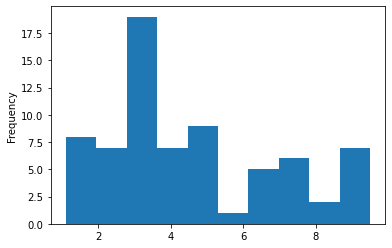

In [46]:
%matplotlib inline
df.complexity.plot.hist()

Объединим рубрики в *text* в одну строку через запятую:

In [37]:
df['rubric'] = [','.join(r) for r in df.rubric]

Давайте почистим текст новостей – уберем оттуда текст, не относящийся к новостям. Найдем лишнее:

In [ ]:
df.text[0]

Лишний текст находится после фразы 'Нашли опечатку?'. Так давайте будем разбивать строки по этой фразе с помощью метода `.split()` и брать все, что до нее (элемент с индексом 0).

In [38]:
df['clean_text'] = [t.split('Нашли опечатку?')[0] for t in df.text]

Осталось только заменить непонятные символы `\xa0` на пробелы:

In [39]:
df['clean_text'] = [t.replace("\xa0", " ") for t in df.clean_text]

In [40]:
df.clean_text[0]

'Российский военно-транспортный самолет Ил-112В совершил первый полет, сообщает Авиационный комплекс имени Ильюшина. Испытания прошли на аэродроме воронежского авиазавода ПАО «ВАСО», командиром экипажа был шеф-пилот ПАО «Ил» Герой России Николай Куимов. Первый полет стал завершением цикла аэродромной отработки, в ходе которой были проведены испытания всех систем, в том числе пробежки по аэродрому. Полет прошел в штатном режиме. В воздухе Ил-112В сопровождал самолет-лаборатория Ил-114ЛЛ. Ил-112В в перспективе должен заменить легкий транспортник Ан-26. Он будет использоваться для перевозки и десантирования легкой техники, грузов и бойцов, его грузоподъемность — около пяти тонн. Самолет сможет развивать скорость до 550 километров в час и совершать полеты на расстояние до 3,4 тысячи километров, а при взлете с грунтовых аэродромов и максимальной загрузкой — до 1,2 тысячи километров. Транспортник сможет взлетать с взлетно-посадочных полос длиной не более 900 метров. Пробег Ил-112В при посадк

Всё! Сохраняем датафрейм в файл. Для разнообразия сохраним в Excel:

In [41]:
df.to_excel('nplus-news.xlsx')